In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras import models
from keras import layers
#from keras import optimizers
#from keras import losses
from keras import metrics

import time

Using TensorFlow backend.


In [2]:
debug = True
#
NEW_LINE = 696919786969
def log(*params):
    if debug:
        if(len(params) == 0):
            print()
        else:
            for x in params:
                if(type(x) is int and x == NEW_LINE):
                    print("\n")
                else:
                    print(x, end="")
                    print(" ", end="")
            if(type(x) is not int or params[-1] != NEW_LINE):
                print()


         fecha  ultimo
0  05-feb-2018   5.779
1  02-feb-2018   5.854
2  01-feb-2018   5.941
3  31-ene-2018   5.983
4  30-ene-2018   5.931 

            fecha  ultimo
5558  02-ene-1996   3.079
5557  03-ene-1996   3.079
5556  04-ene-1996   3.069
5555  05-ene-1996   3.010
5554  08-ene-1996   2.971 

MAX:  15.0 
MIN:  2.701 
DIM:  (5559, 1) 
 


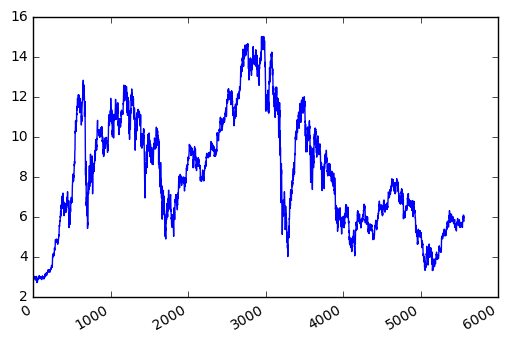

In [3]:
#Cargar datos
datos = pd.read_csv('datos/san_5feb18.csv')

try:
    datos = datos.drop(labels=['apert', 'max', 'min', 'dif', 'vol'], axis=1)
except:
    None #Ya lo eliminaste en el fichero?

log(datos.head(), NEW_LINE)
    
#Poner los datos mas recientes al final...
datos = datos.reindex(index=datos.index[::-1])

log(datos.head(), NEW_LINE)

#Quitamos campo fecha
datos = datos.drop(labels=['fecha'], axis=1)

max = datos.max(1).max()
min = datos.min(1).min()
log("MAX: ", max)
log("MIN: ", min)
log("DIM: ", datos.shape, "\n")


#from datetime import datetime
#x = datos['fecha'].map(lambda x: datetime.strptime(str(x), '%d-%m-%Y'))
x = range(len(datos['ultimo']))
y = datos['ultimo']
plt.plot(x,y)
plt.gcf().autofmt_xdate()
plt.show()

### --------------------------------------------------------------------------------------

In [4]:
#Muestra una grafica de la evolucion del error de training y validacion
def grafica(hist, offset0 = 0, offset1 = None):
    loss = hist.history['loss'][offset0:offset1]
    val_loss = hist.history['val_loss'][offset0:offset1]
    epochs = range(offset0 + 1, len(loss) + offset0 + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [5]:
#Funciones para mostrar tiempo transcurrido
def print_time(time_ini):
    sec = round(time.time() - time_ini)
    min = 0
    if(sec > 60):
        min = sec // 60
        sec = sec & 60
    print("TIME: ", min, "m  ", sec, "s")

def ini_time():
    print("Procesando... ", time.ctime())
    return time.time()

In [6]:
import winsound
def beep():
    duration = 500  # millisecond
    freq = 900  # Hz
    winsound.Beep(freq, duration)
    winsound.Beep(freq, duration)
    winsound.Beep(freq, 2*duration)

In [7]:
#Calcula el error incurrido en la predicción
#import math

##---------------------------------------------------------------------
def error_all(pred, real):
    err = 0
    for i in range(len(real)):
        err += abs(real[i] - pred[i])
    return err / len(real)

In [8]:
#Calcula las predicciones
def datos_prediccion(model, x_tot, y_tot):
    pred = []
    #for i in range(seq_len):
    #    pred.append(y_tot[i])
        
    n = len(x_tot)
    for i in range(n):
        p = model.predict(x_tot[i : i+seq_len])
        pred.append(p[-1])
        if(i % 100 == 0):
            print(".", end="")
    
    real = y_tot
    #for i in range(seq_len):
        #pred.append(pred[-1])
        #real = np.append(real, [real[-1]])
    return [real, pred]

"""
#
def datos_prediccion_adapt(pred0, mul=1.4, off=-0.08):
    pred = []
    for i in range(len(pred0)):
        pred.append(pred0[i] * mul - off)
    return pred"""

#Muestra una grafica con la progresion real y la pedicha
def show_prediccion(real, pred, mul=1, off=0, offset=0, legend=True):
    
    p = []
    for i in range(len(pred)):
        p.append(pred[i] * mul + off)
    
    y = real[offset:]
    x = range(offset, offset + len(y))
    plt.plot(x, y, label='real')

    y = p[offset:]
    x = range(offset, offset + len(y))
    plt.plot(x, y, label='pred')

    if(legend):
        plt.legend()
    plt.show()

### --------------------------------------------------------------------------------------

In [9]:
# Scale data
log(datos[0:4])

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(datos)
datos = scaler.transform(datos)

log(datos[0:4])

datos2= scaler.inverse_transform(datos)
log(datos2[:4])

      ultimo
5558   3.079
5557   3.079
5556   3.069
5555   3.010 
[[0.03073421]
 [0.03073421]
 [0.02992113]
 [0.02512399]] 
[[3.079]
 [3.079]
 [3.069]
 [3.01 ]] 


In [26]:
#Divide los datos en secuencias que el modelo tendrá que aprender
seq_len = 14 # **************************************************************************************************
datos = np.array(datos)
secuencias = []
n_datos = len(datos)
for i in range(n_datos - seq_len+seq_len-1):
    if(i + seq_len > n_datos):
        secuencias.append(datos[-seq_len : ])
        None
    else:
        secuencias.append(datos[i : i + seq_len])
secuencias = np.array(secuencias)
log(len(datos), " / ", datos.shape, " / ", seq_len, " / ", secuencias.shape)

5559  /  (5559, 1)  /  14  /  (5558, 14, 1) 


In [11]:
#Divide los datos en Training y Test
log("SECUENCIAS: ", secuencias.shape, "\n")

row = round(0.90 * secuencias.shape[0])
train = secuencias[:int(row), :]

#np.random.shuffle(train)

x_train = train[:, :-1]#Todos menos el ultimo valor, que es el que hay que predecir
log("X_TRAIN: ", x_train.shape)
y_train = train[:, -1] #El ultimo valor, que es el que interesa predecir
log("Y_TRAIN: ", y_train.shape)

x_test = secuencias[int(row):, :-1]
log("X_TEST: ", x_test.shape)
y_test = secuencias[int(row):, -1]
log("Y_TEST: ", y_test.shape)

SECUENCIAS:  (5549, 14, 1) 
 
X_TRAIN:  (4994, 13, 1) 
Y_TRAIN:  (4994, 1) 
X_TEST:  (555, 13, 1) 
Y_TEST:  (555, 1) 


In [12]:
#Crea la RNN
def build_model():
    model = models.Sequential()
    
    model.add(layers.LSTM(input_shape=(None, 1), units=1, return_sequences=True))
    #model.add(layers.Dropout(0.1))#------------------------

    model.add(layers.LSTM(input_shape=(None, 1), units=1, return_sequences=False))
    #model.add(layers.Dropout(0.1))#------------------------

    model.add(layers.Dense(units=1, activation='sigmoid'))
    #model.add(layers.Activation("linear"))

    model.compile(loss="mse", optimizer="rmsprop")
    return model

In [13]:
#Entrenar la RNN
batch_size=128
epochs = 500 #*******************************************************************************************
model1 = build_model()
timeini = ini_time()
hist1 = model1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)
print_time(timeini)
beep()

Procesando...  Thu Feb  8 17:25:41 2018
TIME:  3 m   24 s


Val.Loss:  0.00014631194656249135


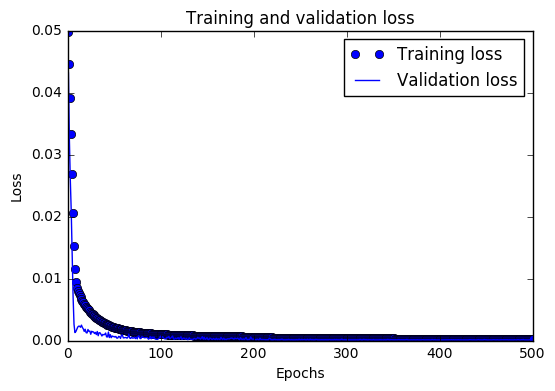

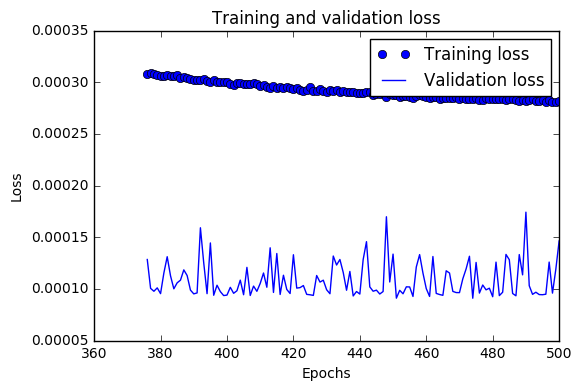

In [14]:
print("Val.Loss: ", hist1.history['val_loss'][epochs-1])
grafica(hist1)
grafica(hist1, 3*epochs//4)

In [15]:
#Error
pred = model1.predict(x_train)
error1 = error_all(y_train, pred)
print("M1 ERROR TRAIN: %.4f -------------------------------" % error1)
pred = model1.predict(x_test)
error1 = error_all(y_test, pred)
print("M1 ERROR TEST:  %.4f -------------------------------" % error1)

M1 ERROR TRAIN: 0.0132 -------------------------------
M1 ERROR TEST:  0.0088 -------------------------------


In [16]:
"""
#Predicciones para grafica
pred0 = []
n_test = len(x_test)
print(x_test.shape)
for i in range(n_test):
    y = model1.predict(x_test[i : i+seq_len])
    pred0.append(y[-1])
    print(".", end="")
    
log(x_test.shape)

real = y_test
pred = []
for i in range(seq_len):
    pred.append(pred0[0])
    real = np.append(real, [real[-1]])
for i in range(len(x_test)):
    pred.append(pred0[i] * 1.4 - 0.08)

show_prediccion(real, pred, False)"""
None

......

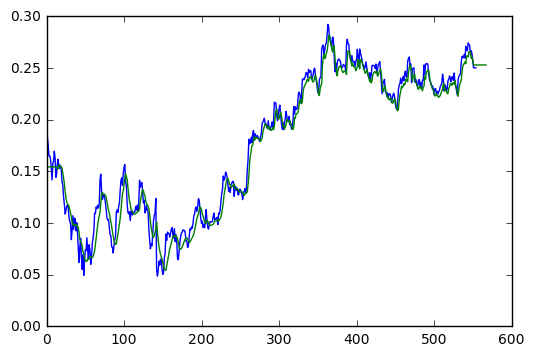

In [44]:
# https://matplotlib.org/users/pyplot_tutorial.html
real1, pred1 = datos_prediccion(model1, x_test, y_test)
for i in range(seq_len-1):
    pred1.insert(0,pred1[0])
show_prediccion(real1, pred1, mul=1, off=0, legend=False)

555 568 55


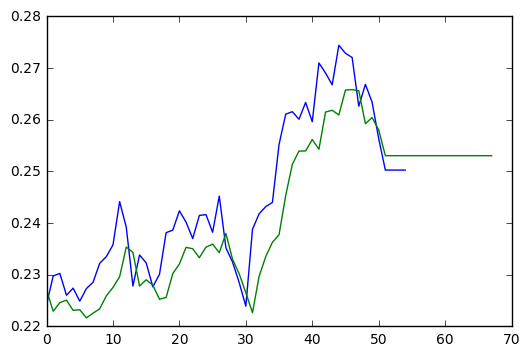

In [45]:
offset = 500
print(len(x_test), len(pred1), len(real1[offset:]))
show_prediccion(real1[offset:], pred1[offset:], off=0, legend=False)

In [ ]:
def secuenciar(datos):
    sec = []
    n_datos = len(datos)
    for i in range(n_datos - seq_len):
        sec.append(datos[i : i + seq_len])
    sec = np.array(sec)
    return sec

In [ ]:
def datos_prediccion2(model, x_tot, n_time):
    pred = []
        
    n = len(x_tot)
    for i in range(n):
        p = model.predict(x_tot[i : i+seq_len])
        pred.append(p[-1])
        if(i % 100 == 0):
            print(".", end="")
            
    
    return real

In [19]:
#Entrenar la RNN con todos los datos

train = secuencias
x_tot = train[:, :-1]#Todos menos el ultimo valor, que es el que hay que predecir
log("X_TRAIN: ", x_tot.shape)
y_tot = train[:, -1] #El ultimo valor, que es el que interesa predecir
log("Y_TRAIN: ", y_tot.shape)

batch_size=128
epochs = 700
model_tot = build_model()
timeini = ini_time()
hist_tot = model_tot.fit(x_tot, y_tot, batch_size=batch_size, epochs=epochs, validation_split=0.01, verbose=0)
print_time(timeini)
beep()

X_TRAIN:  (5549, 13, 1) 
Y_TRAIN:  (5549, 1) 
Procesando...  Thu Feb  8 17:29:25 2018
TIME:  6 m   40 s


Val.Loss:  3.494217526167631e-05


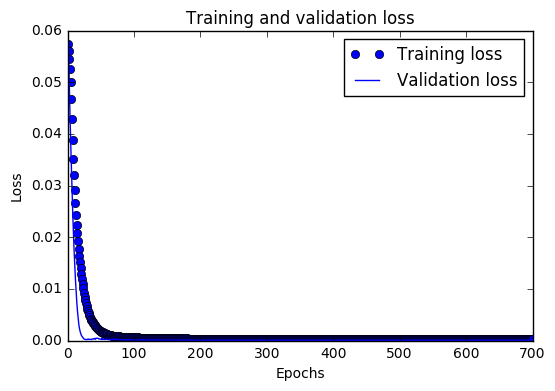

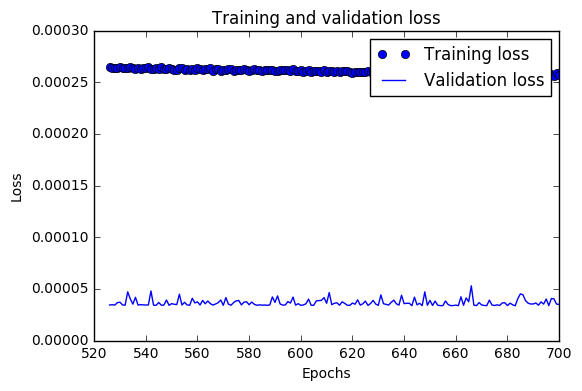

In [20]:
print("Val.Loss: ", hist_tot.history['val_loss'][epochs-1])
grafica(hist_tot)
grafica(hist_tot, 3*epochs//4)

In [21]:
real_tot, pred_tot = datos_prediccion(model_tot, x_tot, y_tot)

........................................................

In [22]:
real_tot_scl = scaler.inverse_transform(real_tot)
pred_tot_scl = scaler.inverse_transform(pred_tot)

n = len(pred_tot_scl)
for i in range(-20, 0):
    print(i+1, n+i, " : ", pred_tot_scl[i], " vs ", real_tot_scl[i])

-19 5529  :  [5.95012055]  vs  [5.84]
-18 5530  :  [5.96342994]  vs  [5.912]
-17 5531  :  [5.93216162]  vs  [5.918]
-16 5532  :  [5.87187076]  vs  [5.9]
-15 5533  :  [5.87187076]  vs  [5.94]
-14 5534  :  [5.87187076]  vs  [5.894]
-13 5535  :  [5.87187076]  vs  [6.034]
-12 5536  :  [5.87187076]  vs  [6.01]
-11 5537  :  [5.87187076]  vs  [5.982]
-10 5538  :  [5.87187076]  vs  [6.076]
-9 5539  :  [5.87187076]  vs  [6.057]
-8 5540  :  [5.87187076]  vs  [6.047]
-7 5541  :  [5.87187076]  vs  [5.931]
-6 5542  :  [5.87187076]  vs  [5.983]
-5 5543  :  [5.87187076]  vs  [5.941]
-4 5544  :  [5.87187076]  vs  [5.854]
-3 5545  :  [5.87187076]  vs  [5.779]
-2 5546  :  [5.87187076]  vs  [5.779]
-1 5547  :  [5.87187076]  vs  [5.779]
0 5548  :  [5.87187076]  vs  [5.779]


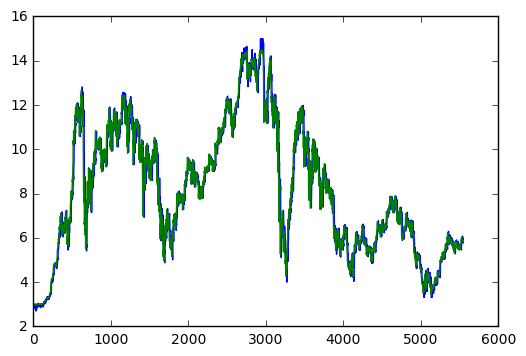

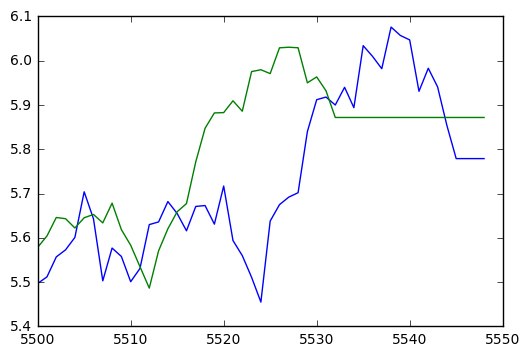

In [23]:
show_prediccion(real_tot_scl, pred_tot_scl, mul=1.0, off=0, legend=False)
show_prediccion(real_tot_scl, pred_tot_scl, offset=5500, mul=1.0, off=0, legend=False)

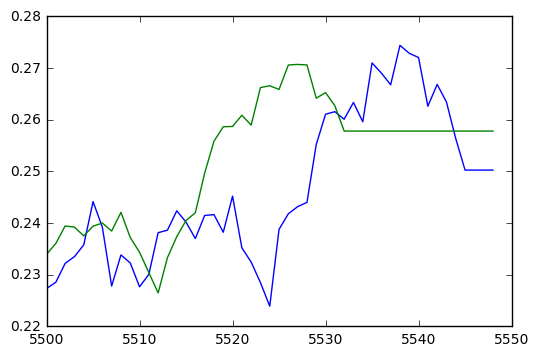

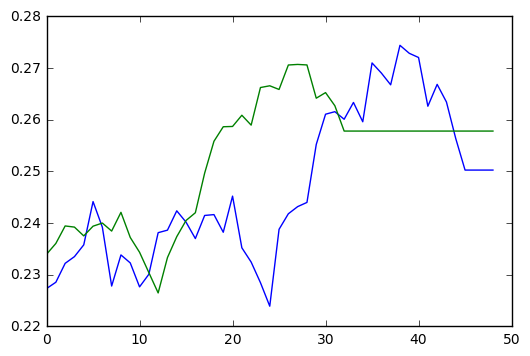

In [24]:
offset = 5500
show_prediccion(real_tot, pred_tot, offset=offset, legend=False)
show_prediccion(real_tot[offset:], pred_tot[offset:], legend=False)

TODO: Mostrar mas predicciones aunque tengas menos datos en la secuencia de entrada
    

In [27]:
n = len(x_tot)
print(x_tot.shape)
for i in range(n - 10 - seq_len, n - seq_len):
    p = model_tot.predict(x_tot[i : i+seq_len])
    print(
        scaler.inverse_transform([p[-2]]),
        scaler.inverse_transform([p[-1]])
        )


(5549, 13, 1)
[[5.97966028]] [[5.97091356]]
[[5.97091356]] [[6.02914118]]
[[6.02914118]] [[6.03048198]]
[[6.03048198]] [[6.02928486]]
[[6.02928486]] [[5.95012055]]
[[5.95012055]] [[5.96342994]]
[[5.96342994]] [[5.93216162]]
[[5.93216162]] [[5.87187076]]
[[5.87187076]] [[5.87187076]]
[[5.87187076]] [[5.87187076]]


In [39]:
#for i in range(-20, 0):
#    print(secuencias[i])
sec = secuencias.copy()
for i in range(0, 2*seq_len):
    np.append(sec, sec[-1])
real_tot9, pred_tot9 = datos_prediccion(model_tot, sec, y_tot)


........................................................

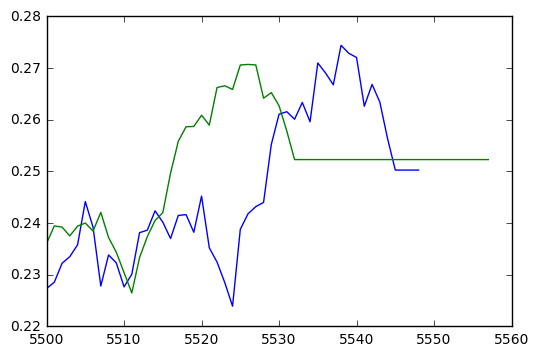

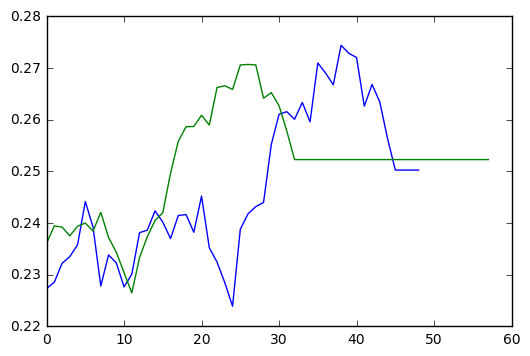

In [40]:
show_prediccion(real_tot, pred_tot9, offset=offset, legend=False)
show_prediccion(real_tot[offset:], pred_tot9[offset:], legend=False)